In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.nn import CrossEntropyLoss

from transformers import (
  AutoTokenizer, 
  AutoModelForSequenceClassification, 
  Trainer, 
  TrainingArguments,
  DataCollatorWithPadding
)

from datasets import Dataset, DatasetDict
from sklearn.metrics import (
  accuracy_score,
  f1_score,
  precision_score,
  recall_score,
  confusion_matrix,
  classification_report
  )
import os
import json

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
processed_df = joblib.load("../../data/processed/processed_ISEC_train_df.joblib")
processed_df

,Issue_id,Component,Title,Description,Status,Resolution,Priority
0,1700,Layout,font size rounded font,piece code gfx round font size way netscape co...,VERIFIED,FIXED,0
1,7991,Plug-ins,land oop plugins mozilla central preffed,need land oop plugins mozilla central preffed ...,RESOLVED,FIXED,0
2,1150,XPCOM,com proxy code crash trying autoproxy paramete...,bug imported bugsplat netscape internal bugsys...,VERIFIED,FIXED,0
3,6143,XUL,crash setting display none grid row nsgrid get...,user agent mozilla gecko firefox build identif...,VERIFIED,FIXED,0
4,5952,Networking: Cache,limit memory cache reasonable value,ram using memory cache change bug take long ti...,VERIFIED,FIXED,0
...,...,...,...,...,...,...,...
52989,53192,Team,replicate functionality ggp,regular use often necessary able copy project ...,RESOLVED,WONTFIX,4
52990,53717,CSS Parsing and Computation,charset improve charset parsing cssloaderimpl ...,separated bug quoted bug additional comment da...,RESOLVED,FIXED,4
52991,53242,Migration,icab profile migrator,,RESOLVED,WONTFIX,4
52992,53682,DOM: Core & HTML,tablesectionelement doesnt default value,overview description tablesectionelement defau...,VERIFIED,FIXED,4


In [4]:
# processed_df["Text"] = (
#   "Title: " + processed_df["Title"].fillna("") + ". " +
#   "Description: " + processed_df["Description"].fillna("") + ". " +
#   "Component: " + processed_df["Component"].fillna("unknown") + ". " +
#   "Status: " + processed_df["Status"].fillna("unknown") + ". " +
#   "Resolution: " + processed_df["Resolution"].fillna("unknown")
# )

In [5]:
processed_df["Text"] = (
  "[TITLE] Title: " + processed_df["Title"].fillna("") + " | " +
  "[DESC] Description: " + processed_df["Description"].fillna("") + " | " +
  "[META] Component: " + processed_df["Component"].fillna("unknown") + " | " +
  "[META] Status: " + processed_df["Status"].fillna("unknown") + " | " +
  "[META] Resolution: " + processed_df["Resolution"].fillna("unknown")
)

In [6]:
processed_df = processed_df[["Text", "Priority"]].copy()
processed_df = processed_df.dropna(subset=["Text", "Priority"])

In [7]:
processed_df

,Text,Priority
0,[TITLE] Title: font size rounded font | [DESC]...,0
1,[TITLE] Title: land oop plugins mozilla centra...,0
2,[TITLE] Title: com proxy code crash trying aut...,0
3,[TITLE] Title: crash setting display none grid...,0
4,[TITLE] Title: limit memory cache reasonable v...,0
...,...,...
52989,[TITLE] Title: replicate functionality ggp | [...,4
52990,[TITLE] Title: charset improve charset parsing...,4
52991,[TITLE] Title: icab profile migrator | [DESC] ...,4
52992,[TITLE] Title: tablesectionelement doesnt defa...,4


In [8]:
processed_df["label"] = processed_df["Priority"].astype(int)

In [9]:
num_labels = processed_df["label"].nunique()
print(f"Num labels: {num_labels}, classes: {sorted(processed_df['label'].unique())}")

Num labels: 5, classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [10]:
train_df, val_df = train_test_split(
  processed_df,
  test_size=0.1,
  random_state=42,
  stratify=processed_df["label"]
)

print("Train shape: ", train_df.shape)
print("Validation shape: ", val_df.shape)

Train shape:  (47490, 3)
Validation shape:  (5277, 3)


In [11]:
# dfs = [train_df[train_df["label"] == cls] for cls in train_df["label"].unique()]
# max_count = max(len(df) for df in dfs)

# dfs_upsampled = [
#   resample(
#     df,
#     replace=True,
#     n_samples=max_count,
#     random_state=42
#   )
#   if len(df) < max_count else df
#   for df in dfs
# ]

# train_df_balanced = pd.concat(dfs_upsampled).sample(frac=1, random_state=42).reset_index(drop=True)

# print("Balanced class counts:")
# print(train_df_balanced["label"].value_counts())

In [12]:
dataset_train = Dataset.from_pandas(train_df.reset_index(drop=True))
dataset_val = Dataset.from_pandas(val_df.reset_index(drop=True))
ds = DatasetDict({"train": dataset_train, "validation": dataset_val})

In [13]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [14]:
def tokenize_fn(batch):
  tokens = tokenizer(batch["Text"], truncation=True, max_length=296)
  tokens["labels"] = batch["label"]
  return tokens

In [15]:
ds = ds.map(tokenize_fn, batched=True, remove_columns=["Text", "Priority", "label"], keep_in_memory=True)

Map:   0%|          | 0/47490 [00:00<?, ? examples/s]

Map:   0%|          | 0/5277 [00:00<?, ? examples/s]

In [16]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [17]:
y_train = train_df["label"].values
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weights = np.array(weights)
weights = weights / weights.sum() * len(weights)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights: ", class_weights)

Class weights:  tensor([0.3661, 0.3480, 0.1058, 1.4321, 2.7480], device='cuda:0')


In [18]:
model = AutoModelForSequenceClassification.from_pretrained(
  "bert-base-uncased",
  num_labels=num_labels
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
class WeightedTrainer(Trainer):
  def __init__(self, *args, class_weights=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.class_weights = class_weights.to(self.args.device) if class_weights is not None else None
    
  def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
    labels = inputs.get("labels")
    outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
    logits = outputs.logits
    loss_fct = CrossEntropyLoss(weight=self.class_weights)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [20]:
def compute_metric(pred):
  logits = pred.predictions
  preds = np.argmax(logits, axis=-1)
  labels = pred.label_ids
  
  accuracy = accuracy_score(labels, preds)
  precision_macro = precision_score(labels, preds, average="macro", zero_division=0)
  recall_macro = recall_score(labels, preds, average="macro", zero_division=0)
  f1_macro = f1_score(labels, preds, average="macro")
  
  return {
    "accuracy": accuracy,
    "precision_macro": precision_macro,
    "recall_macro": recall_macro,
    "f1_macro": f1_macro
  }

In [21]:
# Define training arguments
training_args = TrainingArguments(
  output_dir="../models/bert",
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  learning_rate=2e-5,
  num_train_epochs=4,
  eval_strategy="epoch",
  save_strategy="epoch",
  logging_dir="../models/bert/logs/",
  logging_steps=100,
  weight_decay=0.01,
  load_best_model_at_end=True,
  metric_for_best_model="f1_macro",
  fp16=True
)

In [22]:
trainer = WeightedTrainer(
  model=model,
  args=training_args,
  train_dataset=ds["train"],
  eval_dataset=ds["validation"],
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metric,
  class_weights=class_weights
)

C:\Users\rusty\AppData\Local\Temp\ipykernel_27080\1673886968.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [437]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,1.351400,1.404240,0.556377,0.386659,0.415107,0.373452
2,1.284100,1.389712,0.562820,0.405755,0.427604,0.405963
3,1.197700,1.397750,0.566989,0.404015,0.436051,0.413874
4,0.964800,1.460961,0.560546,0.394314,0.439383,0.407201


TrainOutput(global_step=11876, training_loss=1.2444762804565224, metrics={'train_runtime': 5515.3587, 'train_samples_per_second': 34.442, 'train_steps_per_second': 2.153, 'total_flos': 3.1186842522647136e+16, 'train_loss': 1.2444762804565224, 'epoch': 4.0})

In [438]:
trainer.evaluate()

{'eval_loss': 1.3977497816085815,
 'eval_accuracy': 0.5669888194049649,
 'eval_precision_macro': 0.4040153723932045,
 'eval_recall_macro': 0.4360510252958189,
 'eval_f1_macro': 0.41387402984186794,
 'eval_runtime': 38.5653,
 'eval_samples_per_second': 136.833,
 'eval_steps_per_second': 8.557,
 'epoch': 4.0}

C:\Users\rusty\AppData\Local\Temp\ipykernel_27080\3224661968.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


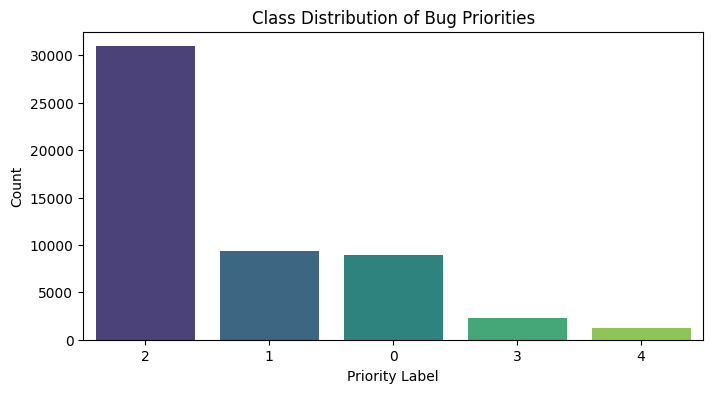

In [23]:
plt.figure(figsize=(8,4))
sns.countplot(
  x="Priority",
  data=processed_df,
  order=processed_df["Priority"].value_counts().index,
  palette="viridis"
)

plt.title("Class Distribution of Bug Priorities")
plt.xlabel("Priority Label")
plt.ylabel("Count")
plt.show()

In [24]:
class_counts = processed_df["Priority"].value_counts()
class_proportions = class_counts / len(processed_df)
print("Class proportions: ", class_proportions)

Class proportions:  Priority
2    0.586427
1    0.178236
0    0.169443
3    0.043323
4    0.022571
Name: count, dtype: float64


In [25]:
predictions = trainer.predict(ds["validation"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

In [26]:
labels = sorted(processed_df["Priority"].unique())
cm = confusion_matrix(y_true, y_pred)

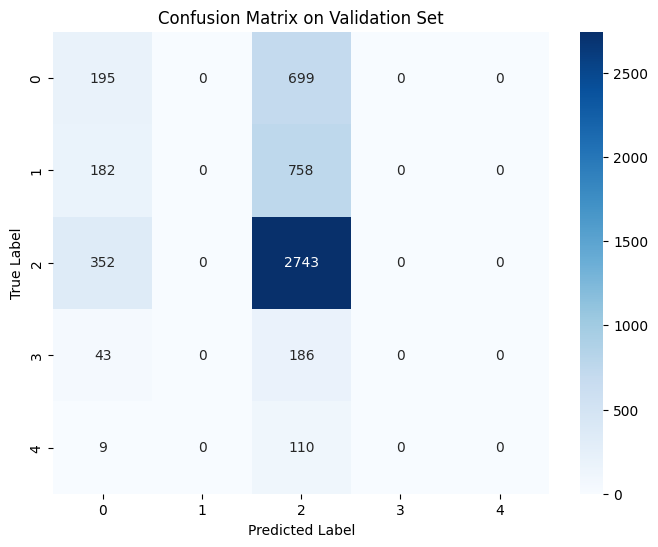

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(
  cm,
  annot=True,
  fmt="d",
  cmap="Blues",
  xticklabels=labels,
  yticklabels=labels
)

plt.title("Confusion Matrix on Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [28]:
cm

array([[ 195,    0,  699,    0,    0],
       [ 182,    0,  758,    0,    0],
       [ 352,    0, 2743,    0,    0],
       [  43,    0,  186,    0,    0],
       [   9,    0,  110,    0,    0]])

In [29]:
label_names = [str(l) for l in labels]
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names, digits=3))

Classification Report:
              precision    recall  f1-score   support

           0      0.250     0.218     0.233       894
           1      0.000     0.000     0.000       940
           2      0.610     0.886     0.723      3095
           3      0.000     0.000     0.000       229
           4      0.000     0.000     0.000       119

    accuracy                          0.557      5277
   macro avg      0.172     0.221     0.191      5277
weighted avg      0.400     0.557     0.463      5277



c:\Users\rusty\miniconda3\envs\bug-triage-env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rusty\miniconda3\envs\bug-triage-env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rusty\miniconda3\envs\bug-triage-env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

In [446]:
trainer.save_model("../models/bert")
tokenizer.save_pretrained("../models/bert")

('../models/bert\\tokenizer_config.json',
 '../models/bert\\special_tokens_map.json',
 '../models/bert\\vocab.txt',
 '../models/bert\\added_tokens.json',
 '../models/bert\\tokenizer.json')

In [30]:
label_map = {
  0: "Critical",
  1: "High",
  2: "Medium",
  3: "Low",
  4: "Trivial"
}

with open("../models/bert/label_map.json", "w") as f:
  json.dump(label_map, f)
  
print("Saved model + tokenizer + label_map")

Saved model + tokenizer + label_map


In [448]:
test_df = pd.read_csv("../../data/raw/test.csv")

In [449]:
test_df.head()

,Issue_id,Component,Title,Description,Status,Resolution
0,6578,JavaScript Engine,Finalize yield syntax to match ES4/JS2 proposal,This tracks Python 2.5. Currently we allow; ;...,VERIFIED,FIXED
1,8050,Networking: Cache,e10s HTTP: offline application cache,I actually know very little about how applicat...,RESOLVED,FIXED
2,5281,DOM: Core & HTML,[FIX]Add GetOwnerDocument on nsIContent or nsG...,See comments in bug 211440; the idea is to add...,RESOLVED,FIXED
3,7871,Layout: View Rendering,Text editing broken in Firebug edit mode and o...,Getting reports that editing is broken in Fire...,VERIFIED,FIXED
4,2411,Plug-ins,shockwave movies redraw improperly on mac(nsbe...,From Bugzilla Helper:; User-Agent: Mozilla/4.7...,VERIFIED,DUPLICATE


In [450]:
# test_df["Text"] = (
#   "Title: " + test_df["Title"].fillna("") + ". " +
#   "Description: " + test_df["Description"].fillna("") + ". " +
#   "Component: " + test_df["Component"].fillna("unknown") + ". " +
#   "Status: " + test_df["Status"].fillna("unknown") + ". " +
#   "Resolution: " + test_df["Resolution"].fillna("unknown")
# )

In [451]:
test_df["Text"] = (
  "[TITLE] Title: " + test_df["Title"].fillna("") + " | " +
  "[DESC] Description: " + test_df["Description"].fillna("") + " | " +
  "[META] Component: " + test_df["Component"].fillna("unknown") + " | " +
  "[META] Status: " + test_df["Status"].fillna("unknown") + " | " +
  "[META] Resolution: " + test_df["Resolution"].fillna("unknown")
)

In [452]:
tokenizer = AutoTokenizer.from_pretrained("../models/bert")
model = AutoModelForSequenceClassification.from_pretrained("../models/bert")
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [32]:
with open("../models/bert/label_map.json", "r") as f:
  label_map = json.load(f)

label_map = {int(k): v for k, v in label_map.items()}
label_map

{0: 'Critical', 1: 'High', 2: 'Medium', 3: 'Low', 4: 'Trivial'}

In [454]:
batch_size = 16
all_preds = []

for i in range(0, len(test_df), batch_size):
  batch_texts = test_df["Text"].iloc[i:i + batch_size].tolist()
  
  inputs = tokenizer(
    batch_texts,
    truncation=True,
    max_length=296,
    padding=True,
    return_tensors="pt"
  )

  inputs = {k: v.to(device) for k, v in inputs.items()}
  
  with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    preds = probs.argmax(dim=-1).cpu().numpy()
    all_preds.extend(preds)
  
test_df["Predicted_Priority"] = [label_map[i] for i in all_preds]

In [455]:
test_df.to_csv("../../data/processed/text_predictions.csv", index=False)